# Практикум на ЭВМ
# Задание 7. Рекомендательная система фильмов

Выполнил: Павел Коваленко, 317 группа

Имеется информация о примерно 6000 пользователях и 4000 фильмах, а также около 1 миллиона оценок фильмов пользователями. Цель работы - по паре (пользователь, фильм) предсказать оценку, которую данный пользователь поставит данному фильму. Для этого мы воспользуемся тремя разными подходами, описанными ниже.

Метрика качества - среднеквадратичная ошибка.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt, rc
%matplotlib inline

In [2]:
font = {'family': 'Verdana',
        'weight': 'normal',
        'size': 14}
rc('font', **font)
rc('legend', fontsize=14)
rc('lines', linewidth=2)

## 1. Content-based подход

В данном подходе для каждой пары (пользователь, фильм) мы пытаемся конструктивно придумать признаковое описание, например, пол, возраст, профессия пользователя, его средний рейтинг по жанрам, жанры фильма. Далее в этом признаковом пространстве мы хотим предсказывать оценку при помощи Ridge-регрессии.

В качестве дополнительных признаков были использованы год выхода фильма и число слов в названии.

In [2]:
ages = [1, 18, 25, 35, 45, 50, 56]
occup = list(range(21))

In [3]:
users = {}
for s in open('ml-1m/users.dat', 'r').readlines():
    t = s.split('::')
    v = [t[1] == 'M']
    a = int(t[2])
    for i in ages:
        v.append(i == a)
    a = int(t[3])
    for i in occup:
        v.append(i == a)
    users[int(t[0])] = v

In [4]:
genres = ['Action', 'Adventure', 'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 
          'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

In [25]:
movies = {}
movies_genres = {}
for s in open('ml-1m/movies.dat', 'r').readlines():
    t = s.split('::')
    v = [len(t[1].split()) - 1, int(t[1].split('(')[-1][:-1])]
    a = t[2].rstrip().split('|')
    movies_genres[int(t[0])] = a
    for i in genres:
        v.append(i in a)
    movies[int(t[0])] = v

In [3]:
from collections import defaultdict

In [4]:
rates = defaultdict(list)
for s in open('ml-1m/ratings.dat', 'r').readlines():
    t = s.split('::')
    rates[int(t[0])].append((int(t[1]), int(t[2]), int(t[3])))

In [5]:
import math
train_frac = 0.8
val_frac = 0.6
train = []
val = []
test = []
for u, itemList in rates.items():
    # itemList = [(i, r, t), ...]
    rat = sorted(itemList, key=lambda x: x[2])
    thr = int(math.floor(len(rat) * train_frac))
    tr2 = int(math.floor(len(rat) * val_frac))
    train.extend(map(lambda x: (u, x[0], x[1] / 5.0), rat[:tr2]))
    val.extend(map(lambda x: (u, x[0], x[1] / 5.0), rat[tr2:thr]))
    test.extend(map(lambda x: (u, x[0], x[1] / 5.0), rat[thr:]))
print("ratings in train:", len(train))
print("ratings in validation:", len(val))
print("ratings in test:", len(test))
y_train = [t[-1] for t in train]
y_train = np.array(y_train)
y_val = [t[-1] for t in val]
y_val = np.array(y_val)
y_test = [t[-1] for t in test]
y_test = np.array(y_test)

ratings in train: 597742
ratings in validation: 200016
ratings in test: 202451


### Формирование признакового описания

In [9]:
def compute_clicks(train):
    def dict_gen():
        return defaultdict(float)
    user_genre_cnt = defaultdict(dict_gen)
    user_genre_clc = defaultdict(dict_gen)
    film_avg_cnt = defaultdict(float)
    film_avg_clc = defaultdict(float)
    
    for u, v, r in train:
        for g in movies_genres[v]:
            user_genre_cnt[u][g] += 1
            user_genre_clc[u][g] += r
        user_genre_cnt[u]['All'] += 1
        user_genre_clc[u]['All'] += r
        film_avg_cnt[v] += 1
        film_avg_clc[v] += r
        
    for v in film_avg_clc.keys():
        film_avg_clc[v] /= film_avg_cnt[v]
    
    for u in user_genre_clc.keys():
        for g in user_genre_clc[u].keys():
            user_genre_clc[u][g] /= user_genre_cnt[u][g]
            
    return user_genre_clc, film_avg_clc

In [10]:
user_genre_avg, film_avg = compute_clicks(train)

In [47]:
def transform_train(train):
    res = []
    for i, (u, v, r) in enumerate(train):
        t = []
        t += users[u]
        t += movies[v]
        f5 = 0
        for g in movies_genres[v]:
            f5 += user_genre_avg[u][g]
        f5 /= len(movies_genres[v])
        t += [f5, user_genre_avg[u]['All'], film_avg[v], 1]
        res.append(t)
    return np.array(res, dtype='float64')

In [26]:
X_train = transform_train(train)

In [48]:
X_val = transform_train(val)

### Подбор параметра регуляризации $\lambda$

In [24]:
from sklearn.metrics import mean_squared_error

In [33]:
from scipy.linalg import solve

In [63]:
lambda_arr = [1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 3e3, 1e4, 1e5]
mse = []
for lambda_ in lambda_arr:
    A = X_train.T.dot(X_train) + lambda_ * np.eye(X_train.shape[1])
    w = solve(A, X_train.T.dot(y_train))
    y_pred = X_val.dot(w)
    mse.append(mean_squared_error(y_val, y_pred))
    print('lambda = %g, mse = %g' % (lambda_, mse[-1]))

lambda = 0.01, mse = 0.0438907
lambda = 0.1, mse = 0.0438887
lambda = 1, mse = 0.0438689
lambda = 10, mse = 0.0436772
lambda = 100, mse = 0.0421176
lambda = 1000, mse = 0.037383
lambda = 3000, mse = 0.0365156
lambda = 10000, mse = 0.0386
lambda = 100000, mse = 0.0467217


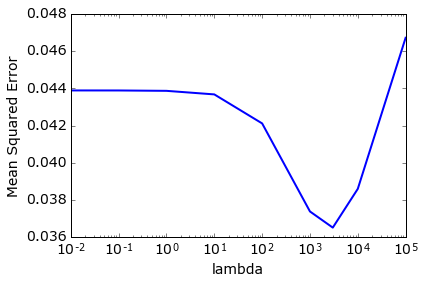

In [70]:
plt.semilogx(lambda_arr, mse)
plt.xlabel('lambda')
plt.ylabel('Mean Squared Error')
plt.show()

Наилучшей точности на отложенной выборке удается достичь при $\lambda = 3000$

### Финальная модель

In [316]:
all_train = train + val

In [75]:
user_genre_avg, film_avg = compute_clicks(all_train)

In [323]:
X_tr2 = transform_train(all_train)
y_tr2 = np.concatenate([y_train, y_val])

In [77]:
X_test = transform_train(test)

In [72]:
lambda_ = lambda_arr[np.argmin(mse)]

In [79]:
A = X_tr2.T.dot(X_tr2) + lambda_ * np.eye(X_tr2.shape[1])
w = solve(A, X_tr2.T.dot(y_tr2))
y_pred = X_test.dot(w)
mse_test = mean_squared_error(y_test, y_pred)
print('lambda = %g, mse = %g' % (lambda_, mse_test))

lambda = 3000, mse = 0.0363473


Ошибка не тестовой выборке - 0.03635

## 2. Neighborhood подход

В данном подходе мы пытаемся предсказать оценку пользователя для фильма исходя из того, какие оценки пользователь поставил похожим фильмам. В качестве меры похожести фильмов будем использовать adjusted cosine similarity, которую можно воспринимать как корреляцию между оценками двух фильмов разными поьзователями.

Поиск похожих фильмов для каждого фильма будем делать распределенным образом в парадигме map-reduce.

### Вычисление списка наиболее похожих фильмов

В данной реализации число похожих фильмов (N), которые требуется найти, никак не влияет ни на скорость работы map-reduce задачи, ни на требуемый для работы объем памяти, посколько используется только на последнем шаге алгоритма, после сортировки всех фильмов по похожести. Поэтому имеет смысл найти за один раз все похожие фильмы, а потом для предсказаний использовать только первые N из них.

Для user-based подхода формулы будут следующими:

Мера схожести между пользователями u и v:

$$sim(u, v) = \frac{\sum\limits_{i \in I} (r_{u, i} - \overline{r_i}) (r_{v, i} - \overline{r_i})}
{\sqrt{\sum\limits_{i \in I} (r_{u, i} - \overline{r_i})^2 \sum\limits_{i \in I} (r_{u, i} - \overline{r_i})^2}}$$

Где $I$ - множество фильмов, оцененных пользователями u и v, $\overline{r_i}$ - средний рейтинг фильма i.

Ответ для новых пользователей нахдится по формуле

$$r_{u, i} = \frac{\sum\limits_{v: r_{v, i} \ne 0} sim(u, v) r_{v, i}} 
{\sum\limits_{v: r_{v, i} \ne 0} sim(u, v)}$$

In [70]:
f = open('input/ratings_train.txt', 'w')
for t in train:
    f.write('%d::%d::%g::0\n' % t)
f.close()

In [71]:
%%file similarity_job.py
from mrjob.job import MRJob
from mrjob.step import MRStep

N = 100000

class SimilarityJob(MRJob):
    
    def steps(self):
         return [MRStep(mapper=self.group_by_users_mapper, 
                        reducer=self.group_by_users_reducer),
                 MRStep(mapper=self.group_by_movie_pairs_mapper, 
                        reducer=self.group_by_movie_pairs_reducer),
                 MRStep(reducer=self.select_N_similar_reducer)]
    
    def group_by_users_mapper(self, key, line):
        user, movie, rating, _ = line.split('::')
        yield int(user), (int(movie), float(rating))
    
    def group_by_users_reducer(self, user, values):
        values = list(values)
        sm = 0
        cnt = 0
        for m, r in values:
            sm += r
            cnt += 1
        mean = round(sm / cnt, 2)
        centered_values = [(movie, rating - mean) for movie, rating in values if abs(rating - mean) > 1e-3]
        yield user, centered_values    
                    
    def group_by_movie_pairs_mapper(self, user, values):
        for i, (m1, r1) in enumerate(values):
            for m2, r2 in values[i:]:
                if m1 < m2:
                    yield (m1, m2), (r1, r2)
                elif m1 > m2:
                    yield (m2, m1), (r2, r1)
        
    def group_by_movie_pairs_reducer(self, mvs, values):
        m1, m2 = mvs
        x2_sum = 0
        y2_sum = 0
        xy_sum = 0
        for x, y in values:
            x2_sum += x ** 2
            y2_sum += y ** 2
            xy_sum += x * y
        sim = xy_sum / (x2_sum * y2_sum) ** 0.5
        if sim > 0:
            yield m1, (m2, sim)
            yield m2, (m1, sim)
            
    def select_N_similar_reducer(self, movie, values):
        values = list(values)
        top = sorted(values, key=lambda x: -x[1])[:N]
        yield movie, top

if __name__ == '__main__':
    SimilarityJob.run()

Overwriting similarity_job.py


In [10]:
%%time
! python similarity_job.py input/ratings_train.txt > output/similarities.txt

Wall time: 1h 35min 34s


No configs found; falling back on auto-configuration
Creating temp directory C:\Users\7636~1\AppData\Local\Temp\similarity_job.РџР°РІРµР».20160506.002040.733663
Running step 1 of 3...
Running step 2 of 3...
Running step 3 of 3...
Streaming final output from C:\Users\7636~1\AppData\Local\Temp\similarity_job.РџР°РІРµР».20160506.002040.733663\output...
Removing temp directory C:\Users\7636~1\AppData\Local\Temp\similarity_job.РџР°РІРµР».20160506.002040.733663...


In [11]:
import json

In [14]:
sim = defaultdict(list)
for s in open('output/similarities.txt', 'r').readlines():
    t = s.split('\t')
    movie = int(t[0])
    sm = json.loads(t[1])
    sim[movie] = sm

In [39]:
# from importlib import reload

In [47]:
# import sys
# sys.stdout.buffer = sys.stdin.buffer
# sys.stderr.buffer = sys.stdin.buffer

In [63]:
# Другой способ запуска mrjob
# import similarity_job
# reload(similarity_job)
# mr_job = similarity_job.SimilarityJob(args=['input/ratings.txt'])

# sim = defaultdict(list)

# with mr_job.make_runner() as runner:
#     runner.run()
#     for line in runner.stream_output():
#         key, value = mr_job.parse_output_line(line)
#         sim[key] = value

### Исследование зависимости ошибки от числа соседей N

In [74]:
user_rates = defaultdict(lambda: defaultdict(float))
for u, i, r in train:
    user_rates[u][i] = r

In [75]:
def sim_predict(user, movie, N):
    sum1 = 0
    sum2 = 0
    for m, s in sim[movie][:N]:
        if m in user_rates[user]:
            sum1 += s * user_rates[user][m]
            sum2 += s
    if sum2 == 0:
        return 0
    return min(1, max(0, sum1 / sum2))

In [76]:
from time import clock

In [77]:
N_arr = [50, 100, 200, 400, 800, 1000, 1500, 2000]
mse_train = []
mse_val = []
time_train = []
time_val = []
for N in N_arr:
    start = clock()
    y_pred = [sim_predict(u, i, N) for u, i, r in train]
    mse_train.append(mean_squared_error(y_train, y_pred))
    time_train.append(clock() - start)
    start = clock()
    y_pred = [sim_predict(u, i, N) for u, i, r in val]
    mse_val.append(mean_squared_error(y_val, y_pred))
    time_val.append(clock() - start)
    print('N: %d, MSE on validation: %g, time on validation: %g' % (N, mse_val[-1], time_val[-1]))

N: 50, MSE on validation: 0.456142, time on validation: 6.91844
N: 100, MSE on validation: 0.409155, time on validation: 12.7905
N: 200, MSE on validation: 0.284941, time on validation: 22.9822
N: 400, MSE on validation: 0.104116, time on validation: 45.8545
N: 800, MSE on validation: 0.0396523, time on validation: 99.5487
N: 1000, MSE on validation: 0.0364285, time on validation: 120.753
N: 1500, MSE on validation: 0.0352146, time on validation: 175.497
N: 2000, MSE on validation: 0.0352152, time on validation: 189.185


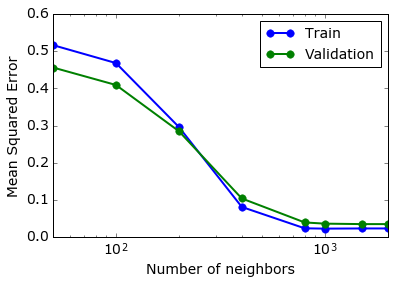

In [78]:
plt.semilogx(N_arr, mse_train, label='Train', marker='.', ms = 15)
plt.semilogx(N_arr, mse_val, label='Validation', marker='.', ms = 15)
plt.legend(loc='upper right')
plt.xlabel('Number of neighbors')
plt.ylabel('Mean Squared Error')
plt.xlim(N_arr[0], N_arr[-1])
plt.show()

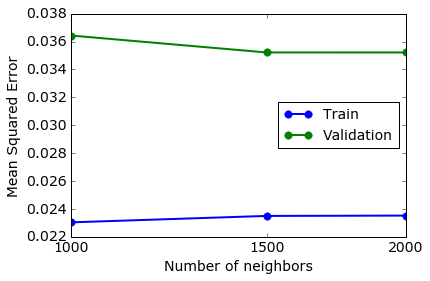

In [82]:
plt.semilogx(N_arr[5:], mse_train[5:], label='Train', marker='.', ms = 15)
plt.semilogx(N_arr[5:], mse_val[5:], label='Validation', marker='.', ms = 15)
plt.legend(loc='best')
plt.xlabel('Number of neighbors')
plt.ylabel('Mean Squared Error')
plt.xlim(N_arr[5], N_arr[-1])
plt.xticks(N_arr[5:], N_arr[5:])
plt.show()

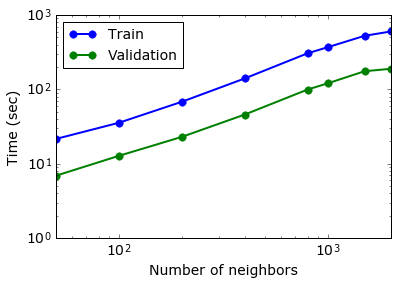

In [83]:
plt.loglog(N_arr, time_train, label='Train', marker='.', ms = 15)
plt.loglog(N_arr, time_val, label='Validation', marker='.', ms = 15)
plt.legend(loc='best')
plt.xlabel('Number of neighbors')
plt.ylabel('Time (sec)')
plt.xlim(N_arr[0], N_arr[-1])
plt.show()

In [81]:
print('Min MSE: %g, best N: %d' % (np.min(mse_val), N_arr[np.argmin(mse_val)]))

Min MSE: 0.0352146, best N: 1500


Судя по полученным результатам, наименьшей ошибки удается достичь при использовании информации о 1500 похожих фильмах, при использовании всех фильмов качество незначительно ухудшается. 

Время работы предсказания ответов линейно зависит от числа рассматриваемых соседей, чего и следовало ожидать.

### Финальная модель

In [64]:
user_rates = defaultdict(lambda: defaultdict(float))
for u, i, r in train + val:
    user_rates[u][i] = r

In [65]:
N = N_arr[np.argmin(mse_val)]
y_pred = [sim_predict(u, i, N) for u, i, r in test]
print('MSE: ', mean_squared_error(y_test, y_pred))

MSE:  0.0362523662054


Ошибка на тестовой выборке - 0.3625

## 3. Latent Factor подход

В данном подходе мы пытаемся найти признаковое пространство одновременно для фильмов и для пользователей, в котором скалярное произведение для пользователя и фильма имеет смысл оценки, которую данный пользователь поставит данному фильму. При фиксированной размерности пространства мы находим описания для пользователей и фильмов итеративно. Сначала фиксируется описание фильмов и находится оптимальное описание пользователей, затем наоборот, и так до сходимости.

Шаг перенастройки весов для $q_i$:

Обозначим за $P[i]$ столбцы $P$, соответствующие пользователям, оценившим фильм $i$, $n_i$ - число пользователей, оценивших фильм $i$, $r_i$ - вектор оценок фильма $i$. 

$$A_i = P[i]^T P[i]$$
$$d_i = P[i]^T r_i$$
$$q_i = (\lambda_q n_i I + A_i) ^ {-1} d_i$$

In [15]:
from scipy.sparse import csr_matrix

In [16]:
data_tr = [t[2] for t in train]
i_tr = [t[0] for t in train]
j_tr = [t[1] for t in train]
R = csr_matrix((data_tr, (i_tr, j_tr)))

In [17]:
n_u = np.array([R[i].nonzero()[0].shape[0] for i in range(R.shape[0])])

In [18]:
n_i = np.array([R[:, i].nonzero()[0].shape[0] for i in range(R.shape[1])])

In [19]:
R1 = R.toarray()

In [20]:
users_nonzero = [R[i].nonzero()[1] for i in range(R.shape[0])]

In [21]:
movies_nonzero = [R[:, i].nonzero()[0] for i in range(R.shape[1])]

### Поиск оптимального числа итераций

In [276]:
K = 10
N = 30
l_p = 0.2
l_q = 0.001

In [277]:
mse_train = []
mse_val = []
P = 0.1 * np.random.random((R.shape[0], K))
Q = 0.1 * np.random.random((R.shape[1], K))
for iteration in range(N):
    Q1 = Q[:, None, :] * Q[:, :, None]
    for u in range(R.shape[0]):
        if n_u[u] == 0:
            continue
        r = R1[u]
        A = Q1[users_nonzero[u]].sum(axis=0) + l_p * n_u[u] * np.eye(K)
        du = Q.T.dot(r.T)
        P[u] = solve(A, du).ravel()
    P1 = P[:, None, :] * P[:, :, None]
    for i in range(R.shape[1]):
        if n_i[i] == 0:
            continue
        r = R1[:, i]
        A = P1[movies_nonzero[i]].sum(axis=0) + l_q * n_i[i] * np.eye(K)
        di = P.T.dot(r)
        Q[i] = solve(A, di).ravel()
    y_pred = np.array([P[u].dot(Q[i]) for u, i, r in train])
    mse_train.append(mean_squared_error(y_train, y_pred))
    y_pred = np.array([P[u].dot(Q[i]) for u, i, r in val])
    mse_val.append(mean_squared_error(y_val, y_pred))

Wall time: 7min 44s


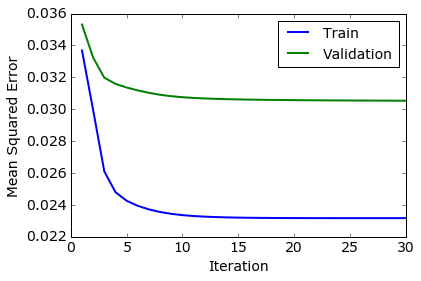

In [278]:
plt.plot(np.arange(1, len(mse_train) + 1), mse_train, label='Train')
plt.plot(np.arange(1, len(mse_train) + 1), mse_val, label='Validation')
plt.legend(loc='upper right')
plt.xlabel('Iteration')
plt.ylabel('Mean Squared Error')
plt.show()

Из этого графика видно, что после 15 итераций среднеквадратичная ошибка почти не изменяется, поэтому в дальнейшем ограничимся 15 итерациями

### Поиск оптимальных параметров $\lambda_p$ и $\lambda_q$

In [293]:
lp_arr = [1e0, 3e-1, 1e-1, 3e-2, 1e-2]
lq_arr = [1e-2, 3e-3, 1e-3, 3e-4, 1e-4]
N = 15
K = 10
mse_train = np.zeros((len(lp_arr), len(lq_arr)))
mse_val = np.zeros((len(lp_arr), len(lq_arr)))
for lpi, l_p in enumerate(lp_arr):
    for lqi, l_q in enumerate(lq_arr):
        P = 0.1 * np.random.random((R.shape[0], K))
        Q = 0.1 * np.random.random((R.shape[1], K))
        for iteration in range(N):
            Q1 = Q[:, None, :] * Q[:, :, None]
            for u in range(R.shape[0]):
                if n_u[u] == 0:
                    continue
                r = R1[u]
                A = Q1[users_nonzero[u]].sum(axis=0) + l_p * n_u[u] * np.eye(K)
                du = Q.T.dot(r.T)
                P[u] = solve(A, du).ravel()
            P1 = P[:, None, :] * P[:, :, None]
            for i in range(R.shape[1]):
                if n_i[i] == 0:
                    continue
                r = R1[:, i]
                A = P1[movies_nonzero[i]].sum(axis=0) + l_q * n_i[i] * np.eye(K)
                di = P.T.dot(r)
                Q[i] = solve(A, di).ravel()
        y_pred = np.array([P[u].dot(Q[i]) for u, i, r in train])
        mse_train[lpi, lqi] = mean_squared_error(y_train, y_pred)
        y_pred = np.array([P[u].dot(Q[i]) for u, i, r in val])
        mse_val[lpi, lqi] = mean_squared_error(y_val, y_pred)

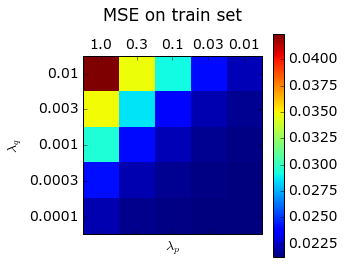

In [294]:
plt.matshow(mse_train.T)
plt.xlabel('$\lambda_p$')
plt.ylabel('$\lambda_q$')
plt.title('MSE on train set\n')
plt.xticks(np.arange(len(lp_arr)), lp_arr)
plt.yticks(np.arange(len(lq_arr)), lq_arr)
plt.colorbar()
plt.show()

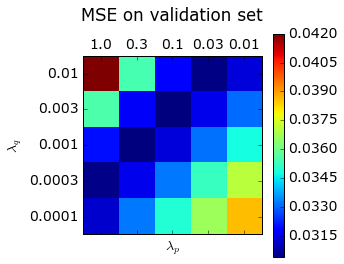

In [295]:
plt.matshow(mse_val.T)
plt.xlabel('$\lambda_p$')
plt.ylabel('$\lambda_q$')
plt.title('MSE on validation set\n')
plt.xticks(np.arange(len(lp_arr)), lp_arr)
plt.yticks(np.arange(len(lq_arr)), lq_arr)
plt.colorbar()
plt.show()

Судя по полученным результатов, наилучшей точности удается достичь при параметрах, предложенных в задании, - $\lambda_p = 0.2, \lambda_q = 0.001$

### Поиск оптимальной размерности пространства K

In [297]:
from time import clock

In [302]:
l_p = 0.2
l_q = 0.001
N = 15
K_arr = [1, 5, 10, 20, 50, 100]
times = []
mse_train = []
mse_val = []
for K in K_arr:
    start = clock()
    P = 0.1 * np.random.random((R.shape[0], K))
    Q = 0.1 * np.random.random((R.shape[1], K))
    for iteration in range(N):
        Q1 = Q[:, None, :] * Q[:, :, None]
        for u in range(R.shape[0]):
            if n_u[u] == 0:
                continue
            r = R1[u]
            A = Q1[users_nonzero[u]].sum(axis=0) + l_p * n_u[u] * np.eye(K)
            du = Q.T.dot(r.T)
            P[u] = solve(A, du).ravel()
        P1 = P[:, None, :] * P[:, :, None]ы
        for i in range(R.shape[1]):
            if n_i[i] == 0:
                continue
            r = R1[:, i]
            A = P1[movies_nonzero[i]].sum(axis=0) + l_q * n_i[i] * np.eye(K)
            di = P.T.dot(r)
            Q[i] = solve(A, di).ravel()
    times.append(clock() - start)
    y_pred = np.array([P[u].dot(Q[i]) for u, i, r in train])
    mse_train.append(mean_squared_error(y_train, y_pred))
    y_pred = np.array([P[u].dot(Q[i]) for u, i, r in val])
    mse_val.append(mean_squared_error(y_val, y_pred))

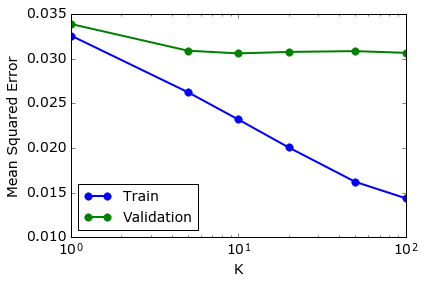

In [312]:
plt.semilogx(K_arr, mse_train, label='Train', marker='.', ms=15)
plt.semilogx(K_arr, mse_val, label='Validation', marker='.', ms=15)
plt.legend(loc='lower left')
plt.xlabel('K')
plt.ylabel('Mean Squared Error')
plt.show()

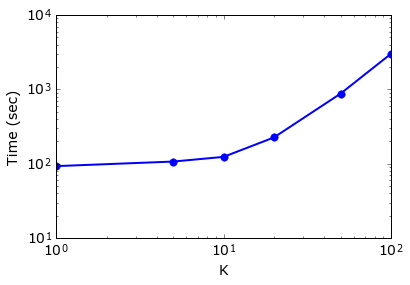

In [313]:
plt.loglog(K_arr, times, marker='.', ms=15)
plt.xlabel('K')
plt.ylabel('Time (sec)')
plt.show()

Как видно из графиков, при K больше 10 действительно происходит переобучение. Увеличение K линейно уменьшает ошибку на тренировочной выборке, однако ошибка на валидационной выборке практически не уменьшается. При этом для K больше 10 время работы алгоритма линейно зависит от K

Таким образом, оптимальными параметрами для этого алгоритма являются $N = 15, K = 10, \lambda_p = 0.2, \lambda_q = 0.001$

### Финальная модель

In [324]:
data_tr = [t[2] for t in all_train]
i_tr = [t[0] for t in all_train]
j_tr = [t[1] for t in all_train]
R = csr_matrix((data_tr, (i_tr, j_tr)))
R1 = R.toarray()

In [325]:
n_u = np.array([R[i].nonzero()[0].shape[0] for i in range(R.shape[0])])
n_i = np.array([R[:, i].nonzero()[0].shape[0] for i in range(R.shape[1])])

In [326]:
users_nonzero = [R[i].nonzero()[1] for i in range(R.shape[0])]
movies_nonzero = [R[:, i].nonzero()[0] for i in range(R.shape[1])]

In [327]:
K = 10
N = 15
l_p = 0.2
l_q = 0.001

In [328]:
P = 0.1 * np.random.random((R.shape[0], K))
Q = 0.1 * np.random.random((R.shape[1], K))
for iteration in range(N):
    Q1 = Q[:, None, :] * Q[:, :, None]
    for u in range(R.shape[0]):
        if n_u[u] == 0:
            continue
        r = R1[u]
        A = Q1[users_nonzero[u]].sum(axis=0) + l_p * n_u[u] * np.eye(K)
        du = Q.T.dot(r.T)
        P[u] = solve(A, du).ravel()
    P1 = P[:, None, :] * P[:, :, None]
    for i in range(R.shape[1]):
        if n_i[i] == 0:
            continue
        r = R1[:, i]
        A = P1[movies_nonzero[i]].sum(axis=0) + l_q * n_i[i] * np.eye(K)
        di = P.T.dot(r)
        Q[i] = solve(A, di).ravel()

In [329]:
y_pred = np.array([P[u].dot(Q[i]) for u, i, r in test])
print('MSE: %g' % mean_squared_error(y_test, y_pred))

MSE: 0.0304066


Ошибка на тестовой выборке - 0.03041

## Заключение

#### Ошибка алгоритма с лучшими параметрами на тестовой выборке

||MSE|
|-|:-:|
|Content-based подход|0.0363473|
|Neighborhood-based подход|0.0362524|
|Latent Factor подход|**0.0304066**|

Из таблицы видно, что Latent Factor подход заметно превосходит по точности остальные два подхода